# Introduction

Simple downloader for historical data

We are going to use https://bitinfocharts.com for now

In [1]:
import re
import datetime as dt
import urllib.request
from typing import List

import pandas as pd
import matplotlib.pyplot as plt

# Helpers

In [2]:
def get_website_as_string(url: str) -> str:
    
    # Header is required so we don't get 403 error
    hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
    req = urllib.request.Request(url, headers=hdr)
    response = urllib.request.urlopen(req)
    content_raw = response.read()
    content = content_raw.decode()
    
    return content   # HTML with embedded script source code

In [3]:
def _parse_datapoint(datapoint_str, p_date, p_float):
    """Parse datapoint string in format '[new Date("2015/07/30"),9.355]' """
    
    date_part, float_part = datapoint_str.strip('[]').split(',')
    
    date_matches = p_date.findall(date_part)
    assert len(date_matches) == 1
    date_str = date_matches[0]
    date_dt = dt.datetime.strptime(date_str, '%Y/%m/%d')
    
#     float_matches = p_float.findall(datapoint_str)
#     print(float_matches)
#     assert len(float_matches) == 1
#     float_str = float_matches[0]
    float_f = float(float_part)
    
    return date_dt, float_f

In [4]:
def extract_data_from_website(content: str, column_name: str):
    p_datapoint = re.compile('\[new Date\("\d+\/\d+\/\d+"\),\d+(?:\.\d+)?\]')
    p_date = re.compile('\d+\/\d+\/\d+')
    p_float = re.compile('\d+(?:\.\d+)?')
    
    list_of_matches: List[str] = p_datapoint.findall(content)
        
    dates_list = []
    values_list = []
    for datapoint_str in list_of_matches:
        date, value = _parse_datapoint(datapoint_str, p_date, p_float)
        dates_list.append(date)
        values_list.append(value)
    
    return pd.Series(data=values_list, index=dates_list, name=column_name)

# Get Historical Data

In [5]:
# Profitability in USD per 1 mega hash per day
# - already accounts for ETH price
# - it is NOT CALIBRATED, i.e. udershots real profitability
#   - maybe beacuse uses only ETH reward and not transaction fees?
url = 'https://bitinfocharts.com/comparison/ethereum-mining_profitability.html'
content = get_website_as_string(url)
series_mining_profitability = extract_data_from_website(content, column_name='profitability')

In [6]:
url = 'https://bitinfocharts.com/comparison/ethereum-price.html'
content = get_website_as_string(url)
series_price = extract_data_from_website(content, column_name='price')

In [7]:
# Cut to only two years
# i.e simulate buying GPUs on 1st Jan 2019 and selling 31 Dec 2020
df = pd.concat([series_mining_profitability, series_price], axis=1)
df.dropna(inplace=True)
# drop first year beacuse ETH price was very high and breaks the plot
df = df[df.index >= dt.datetime(2016, 1, 1)]

In [8]:
df

,profitability,price
2016-01-01,0.0476,0.960
2016-01-02,0.0501,0.966
2016-01-03,0.0498,0.981
2016-01-04,0.0493,0.972
2016-01-05,0.0496,0.975
...,...,...
2021-02-02,0.1080,1439.000
2021-02-03,0.1190,1573.000
2021-02-04,0.1450,1645.000
2021-02-05,0.1510,1674.000


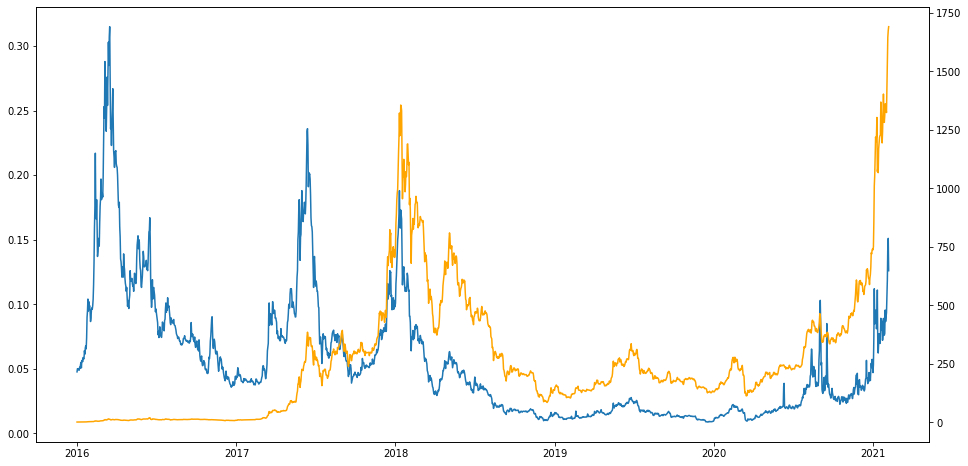

In [9]:
_, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
ax1.plot(df.index, df.profitability, label='profit [$/MH/day]')
ax2.plot(df.index, df.price, color='orange', label='price [$]')
plt.show()

# Calibration

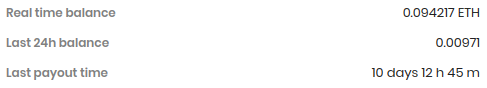

In [10]:
eth_per_day_rig_150MH = 0.00971                                # my personal rig 3x 2080ti, 150MH
eth_price = 1674                                               # current ETH price, 2020-01-07
dollar_per_day_rig_150MH = eth_per_day_rig_150MH * eth_price   # my rig earning per day
dollar_per_day_rig_150MH

16.25454

In [11]:
# dollar per day for 1MH rig (same as historical profitability plot)
dollar_per_day_rig_1MH = dollar_per_day_rig_150MH / 150
dollar_per_day_rig_1MH

0.10836359999999999

In [12]:
# dollar per day reported by the historical data
# - NOTE it's slightly higher than real earned by me for same day
dollar_per_day_form_historical_data = df.loc['2021-02-06'].profitability.item()
dollar_per_day_form_historical_data

0.126

In [13]:
real_multiplier = dollar_per_day_rig_1MH / dollar_per_day_form_historical_data
real_multiplier

0.8600285714285714

In [14]:
# real profitability, dollars per 1MH per day
df['profitability_real'] = df.profitability * real_multiplier

# Electricity Cost

In [15]:
electricity_cost_gbp = 0.1440  # per 1 KWh
electricity_cost_usd = 0.1800  # per 1 KWh

In [16]:
electricity_usage_20MH_RX580 = 0.1  # 100W or 0.1KW
electricity_cost_20MH_RX580_per_day = electricity_cost_usd * electricity_usage_20MH_RX580 * 24
electricity_cost_20MH_RX580_per_day

0.43199999999999994

In [17]:
electricity_cost_per_1MH_per_day = electricity_cost_20MH_RX580_per_day /20
electricity_cost_per_1MH_per_day

0.021599999999999998

In [18]:
df['electricity_cost'] = electricity_cost_per_1MH_per_day

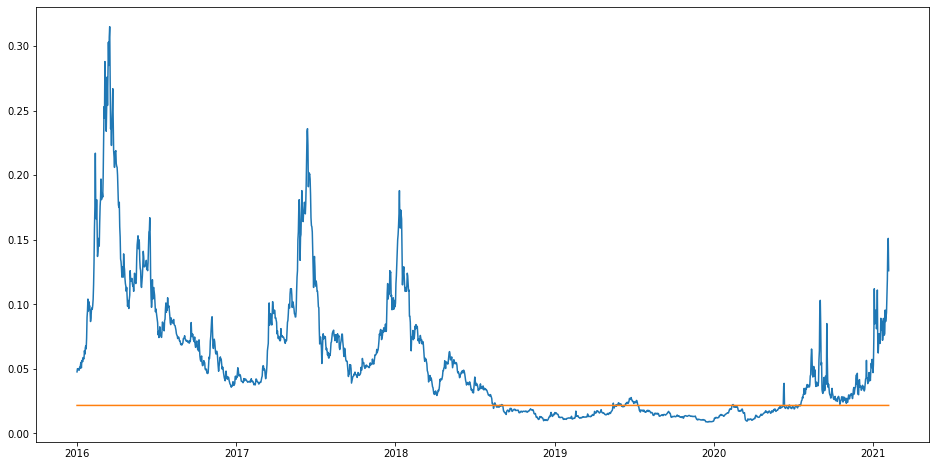

In [98]:
_, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(df.index, df.profitability, label='profit [$/MH/day]')
ax1.plot(df.index, df.electricity_cost,label='elec_cost [$/MH/day]')
plt.show()

# Profit Cumulative 2019 to 2020 - including electricity

In [19]:
df2 = df[df.index >= dt.datetime(2019, 1, 1)]
df2 = df2[df2.index <= dt.datetime(2020, 12, 31)]

In [20]:
df2.profitability.sum() * 20    # 20MH for e.g. RX 580

300.04960000000005

In [21]:
df2.electricity_cost.sum() * 20

315.79200000000003

# Profit Cumulative 2019 to 2020 - ZERO ELECTRICITY

In [22]:
gpu_cost = 220        # cost of RX 580
earned_2years = 300   # ZERO ELECTRICITY
gpu_sale = 100
value_current = earned_2years + gpu_sale
value_current

400

In [29]:
# lookslike 35% annual return, not bad, at ZERO ELECTRICITY COST
220 * (1.35**2)

400.95000000000005